# Time-Frequency Analysis of EEG Data to visaulize Alpha-band Lateralization

This script performs a time-frequency analysis of EEG data to examine differences in power across frequencies and time between two conditions ("left" and "right" - attending trials) and left vs right Electrodes .

---

## **1. Data Preprocessing**
- Loads preprocessed EEG data for multiple subjects.
- Filters data in the 5-15 Hz range using a bandpass filter to isolate relevant frequencies.
- Removes edge artifacts and excludes noisy channels based on a rejection list.

---

## **2. Time-Frequency Representation (TFR)**
- Uses Short-Time Fourier Transform (STFT) to compute the time-frequency representation of power for each trial.
- Separates trials into "left" and "right" conditions and computes average power for each condition across trials.
- Calculates the difference in power between conditions (`right - left`).

---

## **3. Analysis**
- Averages power differences across subjects for each channel, frequency, and time.
- Focuses on the alpha frequency band (8-12 Hz) to compute the lateralization effect.

---

## **4. Visualization**
- Generates time-frequency plots for selected electrode pairs to highlight condition differences:
  - **Electrode-wise TFR:** Displays power difference across frequencies and time for each electrode.
  - **Alpha Power Time Series:** Shows time-resolved alpha power differences for lateralized electrode pairs.



In [12]:
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import stft, butter, sosfilt

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))
analysis_dir = join(data_dir, "analysis")
alpha_dir = join(analysis_dir, "alpha")
decoding_results_dir = join(alpha_dir, "decoding_results") 
plots_dir = join(alpha_dir, "plots")
features_dir = join(alpha_dir, "plots", "features")


In [13]:
def bandpass_filter(data, lowcut, highcut, fs = 120, order=4):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=fs, output='sos')
    return sosfilt(sos, data, axis=-1)

def compute_stft_tfr(data, fs, fmin, fmax, n_fft, nperseg, noverlap):
    """
    Compute STFT-based TFR.
    data shape: (n_trials, n_channels, n_samples)
    
    Returns:
    power: (n_channels, n_freqs, n_times)
    freqs: frequencies array
    times: times array
    """

    n_trials, n_channels, n_samples = data.shape
    # Run STFT on first channel/trial to get the time-frequency grid
    f, t, Zxx = stft(data[0,0,:], fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=n_fft)
    # Select frequencies to display
    freq_mask = (f >= fmin) & (f <= fmax)
    f = f[freq_mask]

    # Compute mean power over trials. Power = abs(Zxx)**2
    all_power = np.zeros((n_trials, n_channels, len(f), len(t)))
    for tr in range(n_trials):
        for ch in range(n_channels):
            _, _, Zxx = stft(data[tr,ch,:], fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=n_fft)
            Zxx = Zxx[freq_mask, :]
            power = np.abs(Zxx)**2
            all_power[tr,ch,:,:] = power
    # Average over trials
    mean_power = all_power.mean(axis=0)  # (n_channels, n_freqs, n_times)
    return mean_power, f, t

In [14]:
subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", 
    "VPpdiq", "VPpdir", "VPpdis", "VPpdit", "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix", 
    "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
]

picks_hubner = [
    "F7", "F3", "Fz", "F4", "F8", "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", 'CPz',
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"
]

subjects_channel_reject = {
    "VPpdib": ["CP2"],
    "VPpdih": ["C3"],
    "VPpdizb": ["Fz"],
    "VPpdizc": ["FC2"]
}

In [15]:
task  = 'covert'
sampling_rate = 120
fmin, fmax = 5, 25 
n_fft = 512
window_length = 1.0  # in seconds
nperseg = int(window_length * sampling_rate)
noverlap = int(nperseg * 0.5)


# Specify channels to plot, Make sure to update *channel pairs* in plotting part accordingly
selected_channels = ['P7', 'P8', 'O1', 'O2', 'CP5', 'CP6', 'FC5', 'FC6'] 
ch_names = selected_channels  # channel names for indexing/plotting

# Initialize lists to collect features and labels from all subjects
all_subject_tfr = []
all_subject_labels = []
selected_indices = [picks_hubner.index(ch) for ch in selected_channels if ch in picks_hubner]
power_tfr_left = []
power_tfr_right = []
ch_map = {ch:i for i,ch in enumerate(ch_names)}

for subject in subjects:
    # Load the NPZ file
    file_dir = os.path.join(derivatives_dir, 'preprocessed', "alpha", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha.npz")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    picks_clean = picks_hubner.copy()
    
    #Adapt indexing for rejected channels
    if subject in subjects_channel_reject:
        # Get the channels to reject for this subject
        channels_to_reject = subjects_channel_reject[subject]
        # Remove all channels from picks_clean
        for channel in channels_to_reject:
            if channel in picks_clean:
                picks_clean.remove(channel)

    npz_data = np.load(file_path)
    X = npz_data['X']  # (n_trials, n_channels, n_samples)
    y = npz_data['y']  # (n_trials,)

    selected_indices = [picks_clean.index(ch) for ch in selected_channels if ch in picks_clean]
    data = X[:, selected_indices, :]
    # Already band-passed to 5,30
    #data = bandpass_filter(data, fmin, fmax)
    data = data[:, :, 60:-60]

    # Separate trials into left and right
    left_mask = (y == 0)
    right_mask = (y == 1)
    X_left = data[left_mask]   # (N_left_trials, n_channels, n_samples)
    X_right = data[right_mask] # (N_right_trials, n_channels, n_samples)

    # Compute TFR for left and right
    power_l, freqs, times = compute_stft_tfr(X_left, sampling_rate, fmin, fmax, n_fft, nperseg, noverlap)
    power_r, freqs, times = compute_stft_tfr(X_right, sampling_rate, fmin, fmax, n_fft, nperseg, noverlap)

    # Store for later averaging across subjects
    power_tfr_left.append(power_l)  # (n_channels, n_freqs, n_times)
    power_tfr_right.append(power_r)

# Stack and average over subjects
power_tfr_left_stack = np.stack(power_tfr_left, axis=0)   # (n_subj, n_channels, n_freqs, n_times)
power_tfr_right_stack = np.stack(power_tfr_right, axis=0) # (n_subj, n_channels, n_freqs, n_times)

# Remove problematic subject
#power_tfr_right_stack = np.delete(power_tfr_right_stack, 1, axis=0)
#power_tfr_left_stack = np.delete(power_tfr_left_stack, 1, axis=0)

# Compute subject-level difference (R - L)
power_tfr_delta_stack = power_tfr_right_stack #- power_tfr_left_stack

# Compute the group-average
power_tfr_delta = np.mean(power_tfr_delta_stack, axis=0)  # (n_channels, n_freqs, n_times)

# Calculate subject-level alpha power difference
alpha_min, alpha_max = 8, 14
alpha_mask = (freqs >= alpha_min) & (freqs <= alpha_max)

# Average the power difference within the alpha band for each subject
# Output shape: (n_subjects, n_channels, n_times)
subject_alpha_power = np.mean(power_tfr_delta_stack[:, :, alpha_mask, :], axis=2)

# Compute the mean and standard error (SE) across subjects
# Resulting shapes: (n_channels, n_times)
alpha_power_mean = np.mean(subject_alpha_power, axis=0)
alpha_power_se   = np.std(subject_alpha_power, axis=0) / np.sqrt(subject_alpha_power.shape[0])

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm

# --- Plotting parameters ---
cmap = 'jet'
vmin, vmax = 0, 1e-11  
xticks = np.linspace(0, 20, 11)
yticks = np.linspace(5, 25, 11)

# account for -0.5 to 20.5 window visualization
# Original times array is integers from 0 to 21
# Shift the times array by -0.5 to get axis from -0.5 to 20.5
times_plot = times - 0.5     # now from -0.5 to 20.5

# Alpha frequency band for averaging
alpha_min, alpha_max = 8, 14
alpha_mask = (freqs >= alpha_min) & (freqs <= alpha_max)
alpha_power = np.mean(power_tfr_delta[:, alpha_mask, :], axis=1)  # shape: (n_channels, n_times)

# Define electrode pairs. They must be included in selected_channels (ch_map)
electrode_pairs = [
    ('FC5', 'FC6'),
    ('CP5', 'CP6'),
    ('P7', 'P8'),
    ('O1', 'O2'),
]


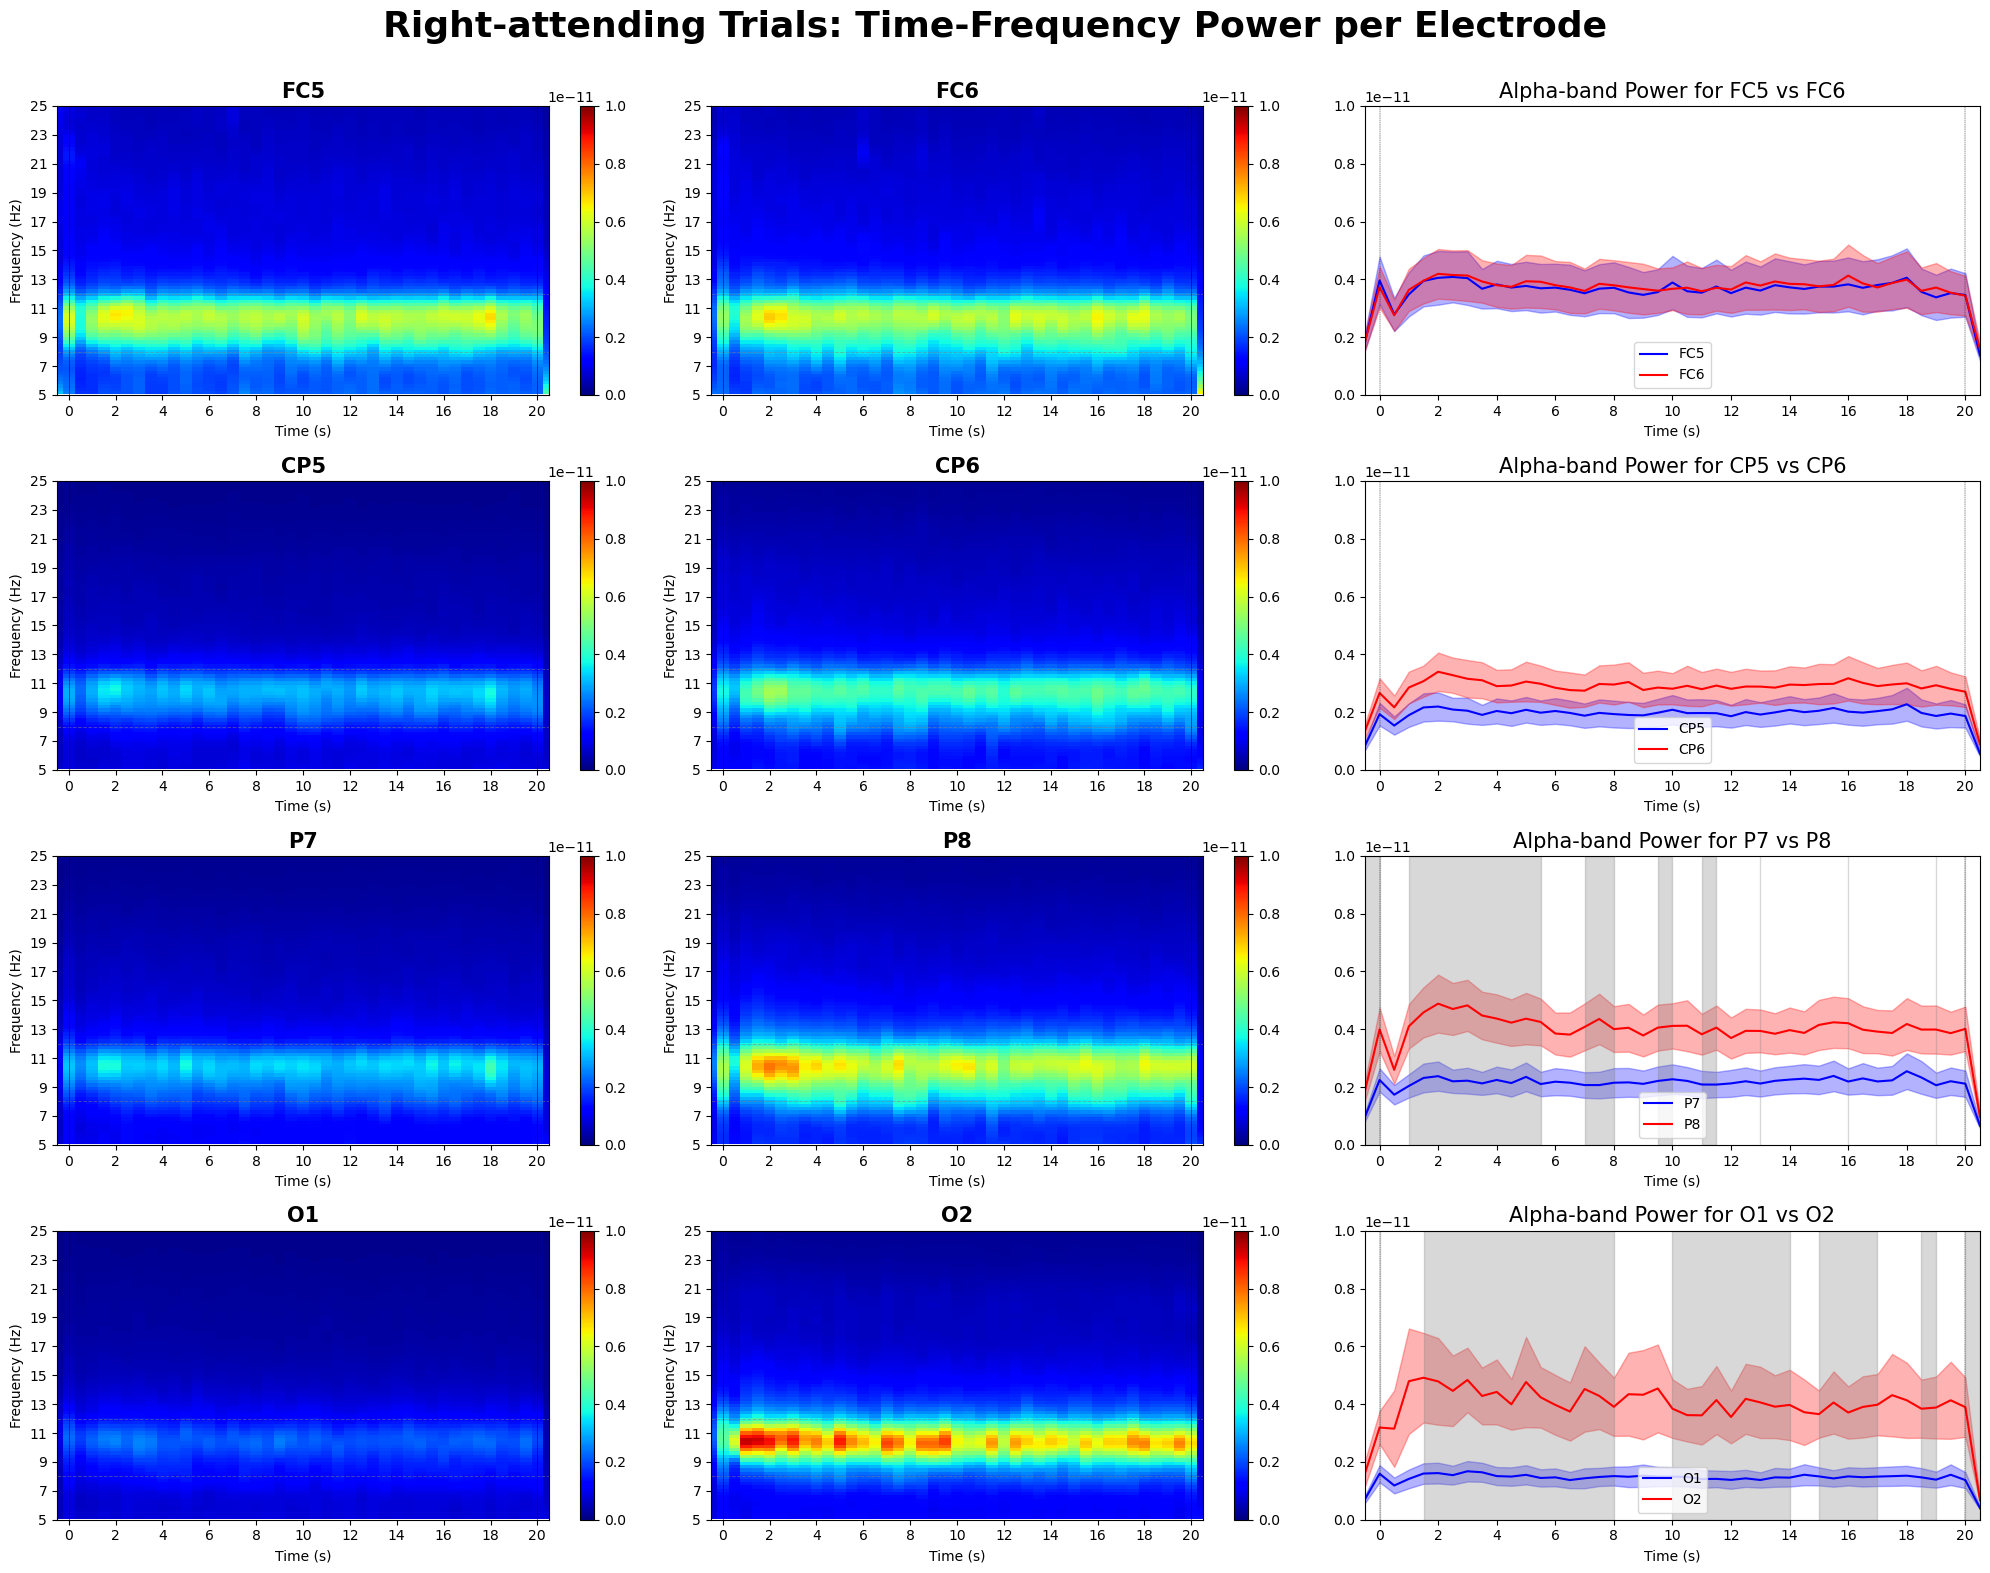

In [17]:

fig = plt.figure(figsize=(20, 4 * len(electrode_pairs)))
fig.suptitle('Right-attending Trials: Time-Frequency Power per Electrode', fontsize=26, fontweight='bold')

gs = gridspec.GridSpec(len(electrode_pairs), 3)

# Loop over electrode pairs
for i, (left_electrode, right_electrode) in enumerate(electrode_pairs):
    left_idx = ch_map[left_electrode]
    right_idx = ch_map[right_electrode]

    # --- Left Electrode TFR ---
    power_channel_left = power_tfr_delta[left_idx]  # shape: (n_freqs, n_times)
    ax = fig.add_subplot(gs[i, 0])
    pcm = ax.pcolormesh(times_plot, freqs, power_channel_left, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label='')
    ax.set_title(f'{left_electrode}', fontsize=15, fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_yticks(yticks)
    ax.axhline(y=8, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
    ax.axhline(y=12, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
    ax.set_xlim(-0.5, 20.5)
    # Vertical bars at t=0 and t=20
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.7, alpha=0.5)
    ax.axvline(x=20, color='k', linestyle='-', linewidth=0.7, alpha=0.5)
    ax.set_xticks(xticks)

    # --- Right Electrode TFR ---
    power_channel_right = power_tfr_delta[right_idx]  # shape: (n_freqs, n_times)
    ax = fig.add_subplot(gs[i, 1])
    pcm = ax.pcolormesh(times_plot, freqs, power_channel_right, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label='')
    ax.set_title(f'{right_electrode}', fontsize=15, fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_yticks(yticks)
    ax.axhline(y=8, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
    ax.axhline(y=12, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
    ax.set_xlim(-0.5, 20.5)
    # Vertical bars at t=0 and t=20
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.7, alpha=0.5)
    ax.axvline(x=20, color='k', linestyle='-', linewidth=0.7, alpha=0.5)
    ax.set_xticks(xticks)

    # --- Alpha Power Time Series with SE and Significance Shading ---
    # Get the mean and SE for the left electrode for the alpha band
    left_mean = alpha_power_mean[left_idx]   # shape: (n_times,)
    left_se   = alpha_power_se[left_idx]       # shape: (n_times,)
    # And for the right electrode
    right_mean = alpha_power_mean[right_idx]   # shape: (n_times,)
    right_se   = alpha_power_se[right_idx]       # shape: (n_times,)

    ax = fig.add_subplot(gs[i, 2])
    # Plot mean time series for left electrode (blue) and right electrode (red)
    ax.plot(times_plot, left_mean, label=left_electrode, color='blue')
    ax.fill_between(times_plot, left_mean - left_se, left_mean + left_se, color='blue', alpha=0.3)
    ax.plot(times_plot, right_mean, label=right_electrode, color='red')
    ax.fill_between(times_plot, right_mean - right_se, right_mean + right_se, color='red', alpha=0.3)
    ax.set_ylim(vmin, vmax)
    ax.set_xlim(-0.5, 20.5)
    ax.set_xticks(xticks)
    # Vertical bars at t=0 and t=20
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.3, alpha=1)
    ax.axvline(x=20, color='k', linestyle='--', linewidth=0.3, alpha=1)
    ax.set_title(f'Alpha-band Power for {left_electrode} vs {right_electrode}', fontsize=15)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("")
    ax.legend(loc='lower center')
    
    # --- Statistical Testing: Compute p-values using a z-test ---
    z_values = (left_mean - right_mean) / np.sqrt(left_se**2 + right_se**2)
    p_values = 2 * norm.sf(np.abs(z_values))
    
    # Create a boolean mask of significant time points (p < 0.05)
    sig_mask = p_values < 0.05
    
    # Add shading to the significant areas.
    # Here, we fill between the y-limits (vmin and vmax) where the significance condition holds.
    ax.fill_between(times_plot, vmin, vmax, where=sig_mask, color='gray', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.94])
fig.subplots_adjust(top=0.92)

plots_dir = os.path.join(alpha_dir, "plots")
os.makedirs(os.path.dirname(plots_dir), exist_ok=True)

plt.savefig(os.path.join(plots_dir, "TFR_alpha_lateralization_left.png"), dpi=300)
plt.savefig(os.path.join(plots_dir, "TFR_alpha_lateralization_left.svg"), dpi=300)
plt.show()
